In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
salader_dogs_vs_cats_path = kagglehub.dataset_download('salader/dogs-vs-cats')

print('Data source import complete.')


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/dogs-vs-cats/train/cats/cat.12067.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.6754.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.12113.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.2602.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.9283.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.5087.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.10515.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.10254.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.6611.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.8950.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.12290.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.4134.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.8313.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.6452.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.244.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.4719.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.7106.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.9879.jpg
/kaggle/input/dogs-vs-cats/

In [3]:
# ✅ STEP 1: Required Libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Input
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization,
    Dropout, RandomFlip, RandomRotation, RandomZoom
)

In [4]:
# ✅ STEP 2: Constants
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16  # ছোট রাখলে RAM কম খায়
IMAGE_SIZE = (128, 128)
EPOCHS = 10

In [5]:
# ✅ STEP 3: Dataset Load with Train/Validation Split
train_ds = keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/dogs-vs-cats/train",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

val_ds = keras.utils.image_dataset_from_directory(
    directory="/kaggle/input/dogs-vs-cats/train",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.


In [6]:
# ✅ STEP 4: Dataset Preprocessing + Augmentation
def prepare_dataset(ds, training=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
                num_parallel_calls=AUTOTUNE)
    if training:
        augmentation = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(0.1),
            RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare_dataset(train_ds, training=True)
val_ds = prepare_dataset(val_ds, training=False)

In [7]:
# ✅ STEP 5: CNN Model Build
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")  # Binary classification
])

In [8]:
# ✅ STEP 6: Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,296,897 (16.39 MB)

 Trainable params: 4,296,449 (16.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# ✅ STEP 7: Callback Setup
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint("best_dogcat.h5", save_best_only=True)
]

In [10]:
# ✅ STEP 8: Train Model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5263 - loss: 1.6206

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 93s 84ms/step - accuracy: 0.5264 - loss: 1.6194 - val_accuracy: 0.5730 - val_loss: 0.6761
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.5937 - loss: 0.6693 - val_accuracy: 0.5255 - val_loss: 0.8192
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6518 - loss: 0.6237

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.6518 - loss: 0.6237 - val_accuracy: 0.7157 - val_loss: 0.5545
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.6922 - loss: 0.5792 - val_accuracy: 0.5867 - val_loss: 0.6710
Epoch 5/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7072 - loss: 0.5626

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.7072 - loss: 0.5625 - val_accuracy: 0.7405 - val_loss: 0.5192
Epoch 6/10
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7510 - loss: 0.5201

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.7510 - loss: 0.5201 - val_accuracy: 0.7735 - val_loss: 0.4696
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 65ms/step - accuracy: 0.7685 - loss: 0.4849 - val_accuracy: 0.7517 - val_loss: 0.5345
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 66s 66ms/step - accuracy: 0.7851 - loss: 0.4633 - val_accuracy: 0.6192 - val_loss: 0.7207
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 65s 65ms/step - accuracy: 0.8065 - loss: 0.4308 - val_accuracy: 0.7450 - val_loss: 0.5102


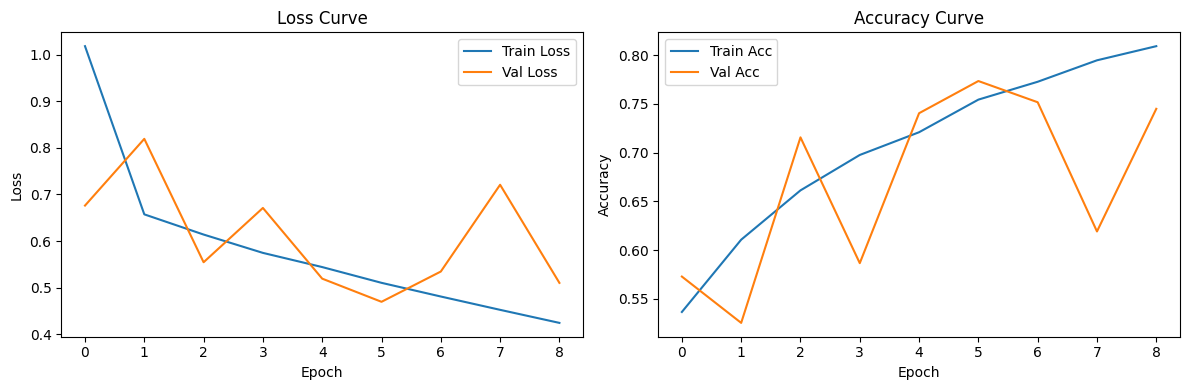

In [11]:
# ✅ STEP 9: Plot Accuracy & Loss
def plot_history(hist):
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(hist.history["loss"], label="Train Loss")
    plt.plot(hist.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(hist.history["accuracy"], label="Train Acc")
    plt.plot(hist.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [15]:
# ✅ STEP 10: Predict Image
def predict_image(model, img_path, threshold=0.5):
    img = cv2.imread(img_path)
    if img is None:
        print("ছবি লোড হয়নি:", img_path)
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMAGE_SIZE)
    input_tensor = np.expand_dims(img_resized / 255.0, axis=0).astype(np.float32)

    prob = model.predict(input_tensor)[0][0]
    label = "Dog" if prob >= threshold else "Cat"
    print(f"Prediction: {label} (Dog probability: {prob:.4f})")

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"{label} ({prob:.2f})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction: Dog (Dog probability: 0.6383)


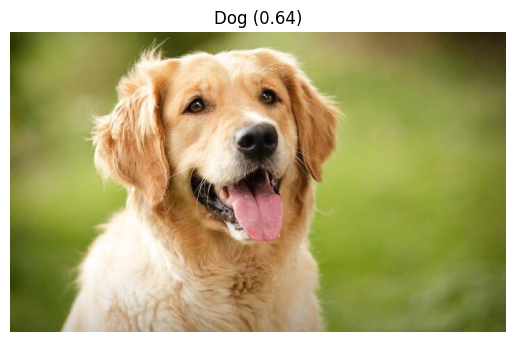

In [16]:
predict_image(model, '/content/dog.jpg')  # আপনার ছবির path দিন

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Cat (Dog probability: 0.0089)


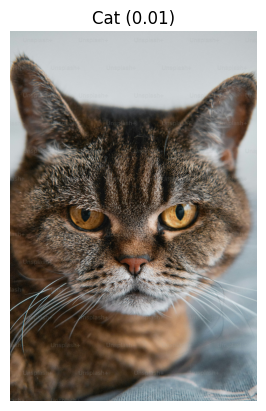

In [18]:
predict_image(model, '/content/premium_photo-1667030474693-6d0632f97029.jpeg')  # আপনার ছবির path দিন

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Prediction: Cat (Dog probability: 0.0110)


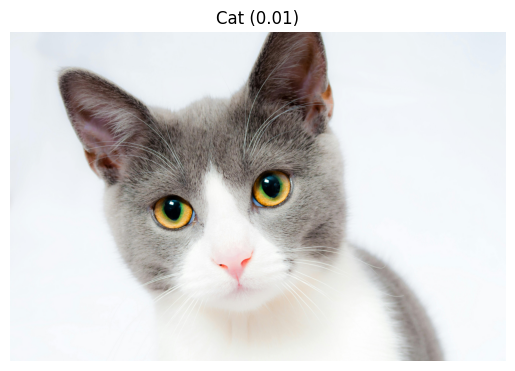

In [20]:
predict_image(model, '/content/pexels-pixabay-104827.jpg')  # আপনার ছবির path দিন

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Dog (Dog probability: 0.7959)


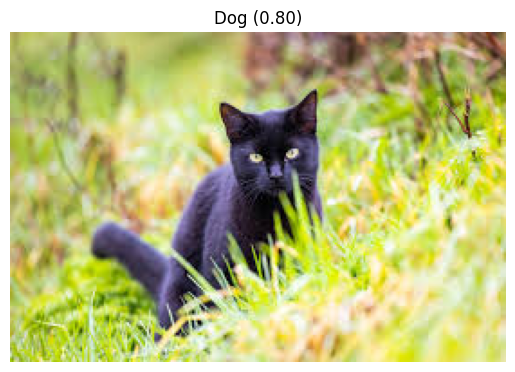

In [30]:
predict_image(model, '/content/images.jpeg',threshold=0.4)  # আপনার ছবির path দিন

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: Cat (Dog probability: 0.2208)


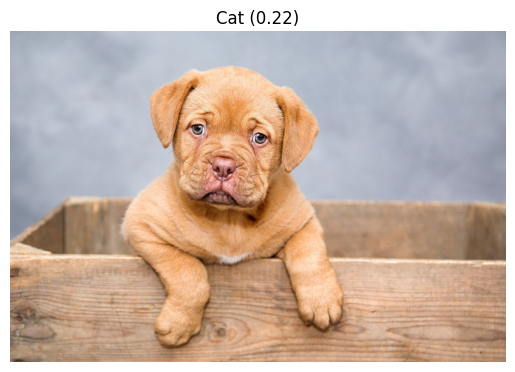

In [31]:
predict_image(model, '/content/puppy-1047521_1280.jpg',threshold=0.6)  # আপনার ছবির path দিন

In [32]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.2f}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7722 - loss: 0.4795
Validation Accuracy: 0.77


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

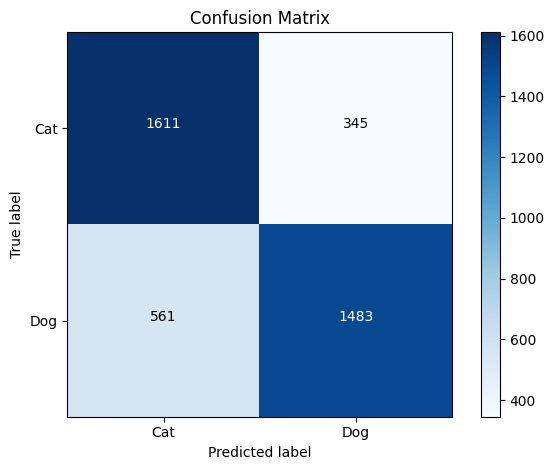

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# ফিচার আর লেবেল আলাদা করুন
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    predictions = (predictions > 0.5).astype(int).flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(predictions)

# কনফিউশন ম্যাট্রিক্স
cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

# Visualization
def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, ["Cat", "Dog"])
plt.show()
